CK+ dataset loaded: 920 samples.
Preprocessed CK+ images: 920 samples, each with 10000 features.


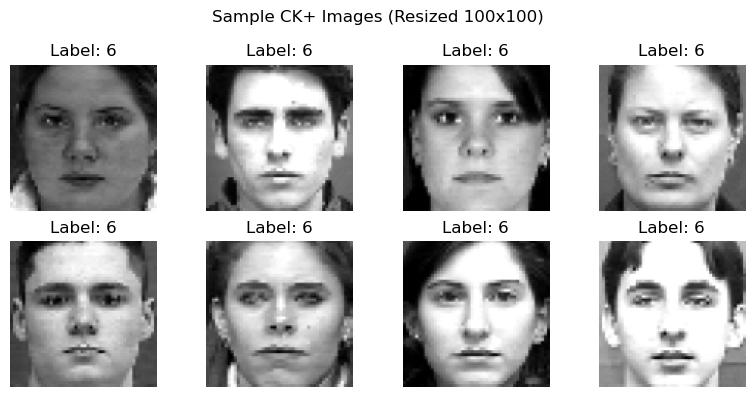

Preprocessed LFW images: 13233 samples, each with 10000 features.


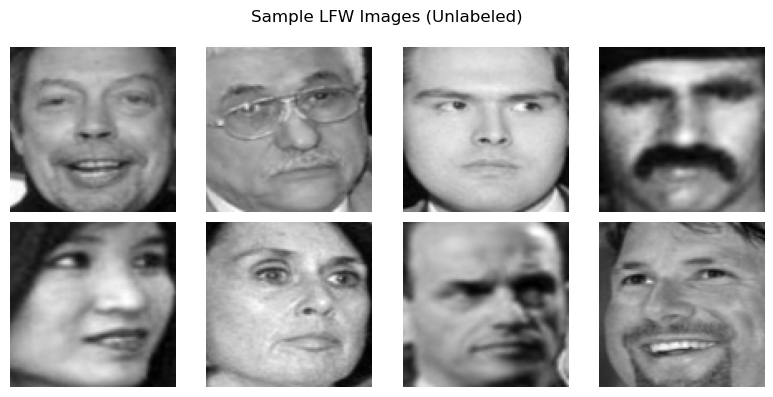

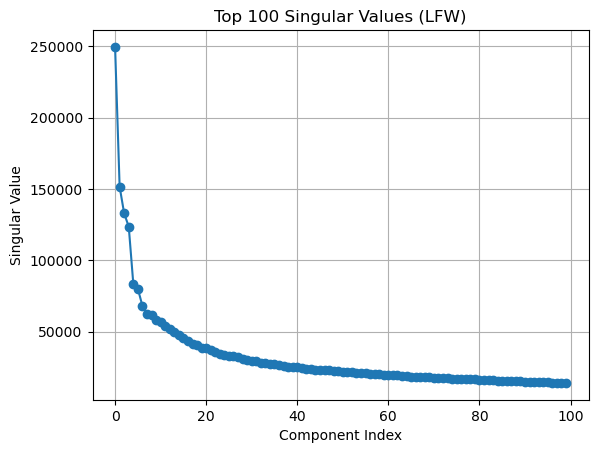

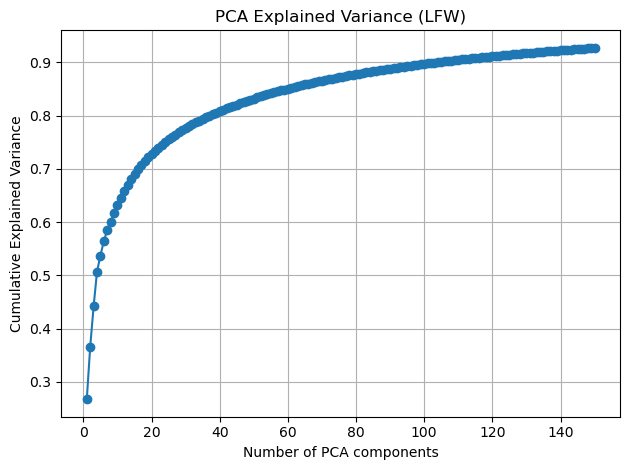

Projected CK+ data: (920, 150)


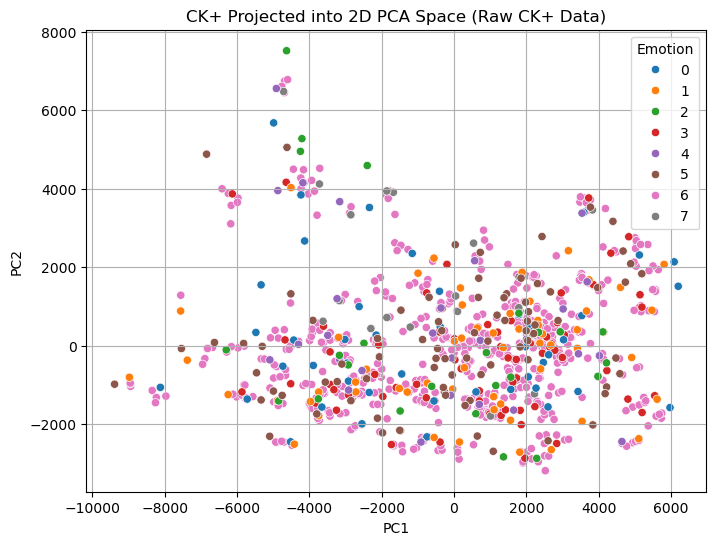

Best SVM params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.8623188405797102
F1: 0.8555844960808677
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.54      0.54        13
           1       0.88      0.83      0.86        18
           2       1.00      0.50      0.67         8
           3       1.00      0.76      0.86        21
           4       0.20      0.12      0.15         8
           5       0.90      0.76      0.83        25
           6       0.90      0.98      0.94       178
           7       0.33      0.40      0.36         5

    accuracy                           0.86       276
   macro avg       0.72      0.61      0.65       276
weighted avg       0.86      0.86      0.86       276



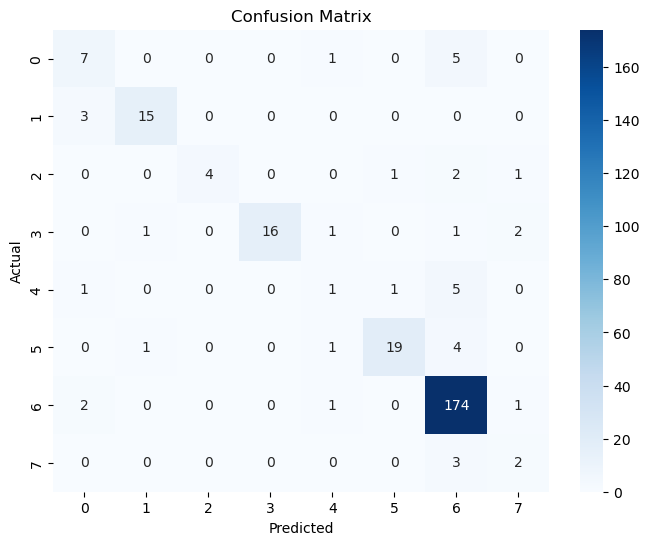

In [1]:
# Facial Expression Recognition using PCA + SVM with Visualizations
# ----------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

np.random.seed(42)

# Step 1: Load and preprocess the labeled CK+ data
ck_df = pd.read_csv('ckextended.csv')
print(f"CK+ dataset loaded: {len(ck_df)} samples.")

X_ck, y_ck = [], []
for idx, row in ck_df.iterrows():
    img = np.fromstring(row['pixels'], dtype=int, sep=' ').reshape(48, 48)
    img_resized = cv2.resize(img.astype('uint8'), (100, 100), interpolation=cv2.INTER_AREA)
    X_ck.append(img_resized.flatten())
    y_ck.append(int(row['emotion']))
X_ck = np.array(X_ck)
y_ck = np.array(y_ck)

print(f"Preprocessed CK+ images: {X_ck.shape[0]} samples, each with {X_ck.shape[1]} features.")

# Visualize some CK+ images
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_ck[i].reshape(100, 100), cmap='gray')
    plt.title(f"Label: {y_ck[i]}")
    plt.axis('off')
plt.suptitle("Sample CK+ Images (Resized 100x100)")
plt.tight_layout()
plt.show()

# Step 2: Load and preprocess LFW
lfw = fetch_lfw_people(min_faces_per_person=0, resize=1.0, color=False)
X_lfw_images = lfw.images
X_lfw = np.array([cv2.resize((img*255).astype('uint8'), (100, 100)).flatten() for img in X_lfw_images])

print(f"Preprocessed LFW images: {X_lfw.shape[0]} samples, each with {X_lfw.shape[1]} features.")

# Visualize some LFW images
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_lfw[i].reshape(100, 100), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample LFW Images (Unlabeled)")
plt.tight_layout()
plt.show()

# Step 3: SVD on LFW (exploration)
X_lfw_centered = X_lfw - np.mean(X_lfw, axis=0)
U, S, VT = np.linalg.svd(X_lfw_centered, full_matrices=False)

plt.figure()
plt.plot(S[:100], 'o-')
plt.title("Top 100 Singular Values (LFW)")
plt.xlabel("Component Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()

# Step 4: PCA on LFW
n_components = 150
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True, random_state=42)
pca.fit(X_lfw)
cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(np.arange(1, n_components+1), cum_var_ratio, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance (LFW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Project CK+ into PCA space
X_ck_pca = pca.transform(X_ck)
print(f"Projected CK+ data: {X_ck_pca.shape}")

# Optional: 2D visualization for original CK+ (before PCA)
pca_2d = PCA(n_components=2)
X_ck_2d = pca_2d.fit_transform(X_ck)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_ck_2d[:,0], y=X_ck_2d[:,1], hue=y_ck, palette='tab10')
plt.title("CK+ Projected into 2D PCA Space (Raw CK+ Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Emotion")
plt.grid(True)
plt.show()

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_ck_pca, y_ck, test_size=0.3, random_state=42, stratify=y_ck)

# Step 7: SVM training
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
best_svm = grid.best_estimator_
print("Best SVM params:", grid.best_params_)

# Step 8: Evaluation
y_pred = best_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


